In [2]:
%matplotlib inline

from IPython.core.magic import register_line_magic
                                
import matplotlib.pyplot as plt

from annoy import AnnoyIndex
import torch.nn as nn

# from fastai.vision import ConvLearner 
from fastai import vision
import fastai
from torchsummary import summary

from PIL import Image
import requests

from tqdm import tqdm


from fastai import torch_core

import torchvision.models as tvm
from torch.utils.data import Dataset, DataLoader
import torch

import cv2
import glob
import numpy as np
import os

# Introduction
installation ![][img-overview]

[img-overview]: https://i.imgur.com/xLtNhLp.png

# Util functions

In [3]:
def imshow(img):
    img = img      # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Data Preparation
TODO: where should one download data or training images?

In [32]:
DATA_PATH = '../data/moma-artworks-1000/'
TRANSFORMATION_PARAMS = dict(
    size=224, 
    padding_mode="zeros"
)

In [33]:
# This class is responsible for transforming images (aka. preprocessing)
# before being feed to a neural network
class ImageDataset(Dataset):
    def __init__(self, root_dir):
        # Look for jpegs in the directory
        self.image_paths = sorted(glob.glob(root_dir + '*.jpeg'))
        assert self.image_paths != 0, "No images found in {}".format(root_dir)

        self.image_names = [os.path.basename(pa2th) for path in self.image_paths]
        _, self.tfms = vision.get_transforms()

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index, with_transformation=True):
        image_path = self.image_paths[index]
        
        # Returns image in RGB format; each pixel ranges between 0.0 and 1.0
        image = vision.open_image(image_path)

        if not with_transformation:
            return image.px

        # Apply transforms to the image        
        return self.transform(self.tfms, image).px
    
    def transform(self, tfms, img):
        return img.apply_tfms(tfms, **TRANSFORMATION_PARAMS)
    
    def get(self, index, **kwargs):
        return self.__getitem__(index, **kwargs)

In [34]:
dataset = ImageDataset(DATA_PATH)

NameError: name 'pa2th' is not defined

In [11]:
print('We have %d images' % len(dataset.image_paths))

We have 5934 images


In [191]:
iter(dataset)

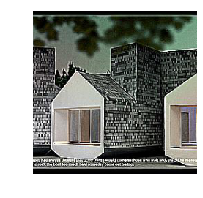

In [21]:
vision.image.show_image(dataset.get(1863))

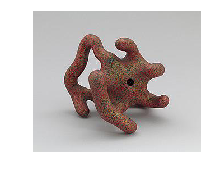

In [22]:
vision.image.show_image(dataset.get(2, with_transformation=False))

# AutoEncoder
image -> encoder -> z -> decoder -> image

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

trainset = torchvision.datasets.FashionMNIST(root='./data/mnist', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, 
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data/mnist', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)



In [138]:
trainset.train_data[0].shape

torch.Size([28, 28])

In [190]:
import inspect
inspect.getfile(mnist.__class__)


'/Users/heytitle/projects/venv-python3/lib/python3.6/site-packages/torchvision/datasets/mnist.py'

In [59]:
NOISE_PARAM = 0.3
class NoisyMNISTDataset(Dataset):
    def __init__(self, train=True, transform=None, noisy_transform=None):
        ds = torchvision.datasets.MNIST(root='./data/mnist', train=train, download=True)
        if train:
            self.data, self.labels = ds.train_data, ds.train_labels
        else:
            self.data, self.labels = ds.test_data, ds.test_labels
        self.transform = transform
        self.noisy_transform =  transforms.Compose([noisy_transform, transform])
        
    def __getitem__(self, index):
        img = self.data[index]
        
        img1 = Image.fromarray(img.numpy(), mode='L')
        x = self.transform(img1)
        
#         img2 = Image.fromarray(img.numpy(), mode='L')
#         x_mod = self.noisy_transform(img2)
        mark = (torch.rand_like(x) < NOISE_PARAM).to(dtype=torch.float32)
        noisy_x = (1-mark)*x + torch.ones_like(x)*mark
        return x, noisy_x
            
    
    def __len__(self):
        return len(self.data)
    
    
noisy_transform = transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0, hue=0.2)


nmnist_train_set = NoisyMNISTDataset(transform=transform, noisy_transform=noisy_transform)
nmnist_test_set = NoisyMNISTDataset(transform=transform, noisy_transform=noisy_transform, train=False)

trainloader = torch.utils.data.DataLoader(nmnist_train_set, batch_size=32, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(nmnist_test_set, batch_size=4, shuffle=False, num_workers=2)

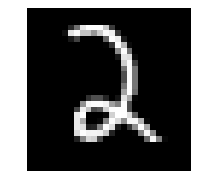

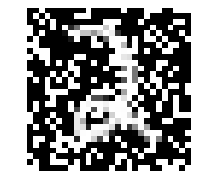

In [43]:
bb = nmnist_test_set[980]

vision.image.show_image(bb[0], cmap='gray')
vision.image.show_image(bb[1], cmap='gray')

In [7]:
import torch.nn.functional as F

import torch.nn as nn
from functools import reduce
import torch.optim as optim

class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(x.size(0), -1)
    
class Reshape(nn.Module):
    def __init__(self, shape):
        super(Reshape, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(x.size(0), *self.shape)

In [8]:
class VanillaVAE(nn.Module):
    def __init__(self, verbose=False):
        super(VanillaVAE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            Flatten(),
            nn.Linear(16 * 5 * 5, 120),
            nn.ReLU(True),
            nn.Linear(120, 84),
            nn.ReLU(True),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(84, 120),
            nn.ReLU(True),
            nn.Linear(120, 16*5*5),
            nn.ReLU(True),
            Reshape([16, 5, 5]),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(16, 6, 5),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(6, 3, 5),
            nn.Tanh()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat
    
    def parameters(self):
        return list(self.encoder.parameters()) + list(self.decoder.parameters())

# VAE

In [9]:
class VAE(nn.Module):
    def __init__(self, latent_dims=2, verbose=False):
        super(VAE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 6, 5),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            Flatten(),
            nn.Linear(16 * 4 * 4, 120),
            nn.ReLU(True),
            nn.Linear(120, 2*latent_dims),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dims, 120),
            nn.ReLU(True),
            nn.Linear(120, 16*4*4),
            nn.ReLU(True),
            Reshape([16, 4, 4]),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(16, 6, 5),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(6, 1, 5),
            nn.Sigmoid()
        )

    def forward(self, x):
        h = self.encoder(x)
        z_mu, z_logvar = torch.chunk(h, 2, dim=1)
        z_mu = z_mu.view(z_mu.size(0), -1)
        z_logvar = z_logvar.view(z_logvar.size(0), -1)
        
        z_logvar = nn.Softplus()(z_logvar)
        
        z = self.sampling(z_mu, z_logvar)

        x_hat = self.decoder(z)
        return x_hat, z, z_mu, z_logvar
    
    def sampling(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
    
    def parameters(self):
        return list(self.encoder.parameters()) + list(self.decoder.parameters())

def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x.view(-1, 28*28), x.view(-1, 28*28), reduction='sum')
    
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return (BCE + KLD) / (mu.shape[0]*mu.shape[1])

# Denoise VAE

In [44]:
class DVAE(nn.Module):
    def __init__(self, latent_dims=2, verbose=False):
        super(DVAE, self).__init__()
        
        self.latent_dims = latent_dims
        self.dm = nn.Linear(128, latent_dims)
        self.dv = nn.Linear(128, latent_dims)

        self.encoder = nn.Sequential(
            Flatten(),
            nn.Linear(784, 512), nn.ReLU(True),
            nn.Linear(512, 128)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dims, 128), nn.ReLU(True),
            nn.Linear(128, 512),  nn.ReLU(True),
            nn.Linear(512, 784), nn.Sigmoid(),
            Reshape([1, 28, 28]),
        )


    def forward(self, x):
        h = self.encoder(x)
        z_mu = self.dm(h)
        
        z_logvar = self.dv(h)
        
        z_logvar = nn.Softplus()(z_logvar)
        
        z = self.sampling(z_mu, z_logvar)

        x_hat = self.decoder(z)
        return x_hat, z, z_mu, z_logvar
    
    def sampling(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
    
    def parameters(self):
        return list(self.encoder.parameters()) + list(self.decoder.parameters()) + \
            list(self.dm.parameters()) + list(self.dv.parameters())



In [45]:
running_loss = []

dvae = DVAE(latent_dims=100)

optimizer = optim.Adam(dvae.parameters(), lr=0.0001)

for epoch in range(5):
    for i, data in enumerate(trainloader, 0):
        x, x_mod = data

        optimizer.zero_grad()

        x_hat, z, z_mu, z_logvar = dvae(x_mod)

        loss = loss_function(x_hat, x, z_mu, z_logvar)


        loss.backward()
        optimizer.step()

        # print statistics
        running_loss.append(loss.item())
        if i % 150 == 149:    
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, np.mean(running_loss)))
            running_loss = []

[1,   150] loss: 3.246
[1,   300] loss: 2.152
[1,   450] loss: 2.088
[1,   600] loss: 2.051
[1,   750] loss: 2.002
[1,   900] loss: 1.992
[1,  1050] loss: 1.989
[1,  1200] loss: 1.965
[1,  1350] loss: 1.959
[1,  1500] loss: 1.953
[1,  1650] loss: 1.952
[1,  1800] loss: 1.916
[2,   150] loss: 1.910
[2,   300] loss: 1.883
[2,   450] loss: 1.865
[2,   600] loss: 1.863
[2,   750] loss: 1.847
[2,   900] loss: 1.842
[2,  1050] loss: 1.813
[2,  1200] loss: 1.798
[2,  1350] loss: 1.753
[2,  1500] loss: 1.746
[2,  1650] loss: 1.724
[2,  1800] loss: 1.723
[3,   150] loss: 1.716
[3,   300] loss: 1.712
[3,   450] loss: 1.699
[3,   600] loss: 1.705
[3,   750] loss: 1.697
[3,   900] loss: 1.705
[3,  1050] loss: 1.682
[3,  1200] loss: 1.691
[3,  1350] loss: 1.687
[3,  1500] loss: 1.671
[3,  1650] loss: 1.670
[3,  1800] loss: 1.659
[4,   150] loss: 1.661
[4,   300] loss: 1.650
[4,   450] loss: 1.642
[4,   600] loss: 1.656
[4,   750] loss: 1.644
[4,   900] loss: 1.638
[4,  1050] loss: 1.638
[4,  1200] 

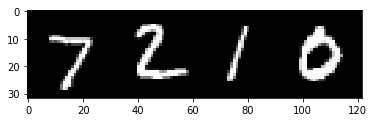

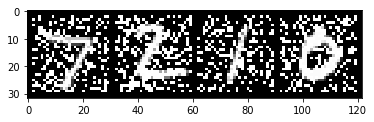

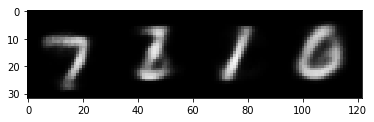

In [48]:
dataiter = iter(testloader)

images, images_mod = dataiter.next()

imshow(torchvision.utils.make_grid(images))
imshow(torchvision.utils.make_grid(images_mod))

reconstructed_imgs, *_ = dvae(images_mod)
reconstructed_imgs = reconstructed_imgs.detach()

imshow(torchvision.utils.make_grid(reconstructed_imgs))

# Use embedding for Classification

In [66]:
dvae.eval()
test_images = np.zeros((len(testloader.dataset), 100))
test_loss = []
with torch.no_grad():
    for i, (x, x_mod) in enumerate(testloader):

        x_hat, z, z_mu, z_logvar = dvae(x_mod)

        test_images[i*4:(i+1)*4] = z
        
        test_loss.append(loss_function(x_hat, x, z_mu, z_logvar).item())

    test_loss = np.mean(test_loss)
    print('====> Test set loss: {:.4f}'.format(test_loss))

====> Test set loss: 1.5729


In [67]:
true_labels = testloader.dataset.labels.numpy()

In [68]:
test_images_normed = test_images / np.sqrt(np.sum(np.power(test_images, 2), axis=1)).reshape((-1, 1))

In [69]:
sim_matrix = test_images_normed.dot(test_images_normed.T)

In [70]:
nearest_neighbors = np.argsort(-sim_matrix, axis=1)
first_nn = nearest_neighbors[:, 1]
predicted_labels = true_labels[first_nn]
print('Predicted from VAE features: accuracy %.4f' % np.mean(true_labels == predicted_labels))

Predicted from VAE features: accuracy 0.5318


In [71]:
raw_images = testloader.dataset.data.view(-1, 784).numpy()
raw_test_images_normed = raw_images / np.sqrt(np.sum(np.power(raw_images, 2), axis=1)).reshape((-1, 1))
raw_sim_matrix = raw_test_images_normed.dot(raw_test_images_normed.T)
raw_nearest_neighbors = np.argsort(-raw_sim_matrix, axis=1)
raw_first_nn = raw_nearest_neighbors[:, 1]
raw_predicted_labels = true_labels[raw_first_nn]
print('Predict from pixel values: accuracy %.4f' % np.mean(true_labels == raw_predicted_labels))

Predict from pixel values: accuracy 0.5373


(10000, 10000)

In [83]:
first_nn = nearest_neighbors[:, 1]

In [89]:
predicted_labels = true_labels[first_nn]

In [90]:
predicted_labels

array([5, 4, 1, 1, ..., 1, 8, 3, 5])

In [ ]:
print('accuracy %.4f' % np.mean(true_labels == predicted_labels))

In [ ]:
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 20, 5),
            nn.BatchNorm2d(20),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(20, 15, 5),
            nn.BatchNorm2d(15),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            Flatten(),
            nn.Linear(15 * 4 * 4, 120),
#             nn.Dropout(p=0.2),
            nn.ReLU(True),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dims, 120),
            nn.ReLU(True),
            nn.Linear(120, 15*4*4),
            nn.ReLU(True),
            Reshape([15, 4, 4]),
            nn.ConvTranspose2d(15, 20, 2),
            nn.BatchNorm2d(20),
            nn.ConvTranspose2d(20, 10, 4),
            nn.BatchNorm2d(10),
            nn.ReLU(True),
            nn.ConvTranspose2d(10, 10, 4),
            nn.BatchNorm2d(10),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(10, 10, 5),
            nn.BatchNorm2d(10),
            nn.ConvTranspose2d(10, 1, 3),
            nn.Sigmoid()
        )

